In [135]:
import numpy as np
import pandas
import matplotlib.pyplot as plt

np.random.seed(42)

In [2]:
from sklearn.datasets import fetch_olivetti_faces

data = fetch_olivetti_faces()

downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to C:\Users\vlcan\scikit_learn_data


In [7]:
data.keys()

dict_keys(['data', 'images', 'target', 'DESCR'])

In [35]:
X, y = data.images.reshape((-1, 64*64)), data.target

In [36]:
from sklearn.model_selection import StratifiedShuffleSplit

splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

for train_val_ids, test_ids in splitter.split(X, y):
    
    for train_ids, val_ids in splitter.split(X[train_val_ids], y[train_val_ids]):
        X_train, y_train = X[train_ids], y[train_ids]
        X_val, y_val = X[val_ids], y[val_ids]
    
    X_test, y_test = X[test_ids], y[test_ids]

In [37]:
print(X_train.shape, X_val.shape, X_test.shape)

(256, 4096) (64, 4096) (80, 4096)


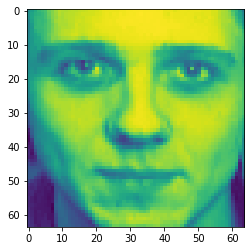

Hi, my name is 11


In [41]:
plt.imshow(X_train[0].reshape((64,64)))
plt.show()

print("Hi, my name is %d" % y_train[0])

In [54]:
from sklearn.cluster import KMeans

inertias = []

for k in range(40, 256, 10):   # min - 40 people; max - 256 instances
    print(f'{k}', end = ' ')
    
    clusterer = KMeans(n_clusters = k, max_iter = 70, n_init = 5)  
    # the smaller hyperparameters make the process faster
    clusterer.fit(X_train)
    
    inertias.append(clusterer.inertia_)

40 50 60 70 80 90 100 110 120 130 140 150 160 170 180 190 200 210 220 230 240 250 

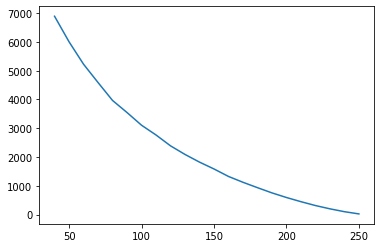

In [56]:
plt.plot(list(range(40, 256, 10)), inertias)  # 120 looks like a good number
plt.show()

In [58]:
clusterer = KMeans(n_clusters = 120)
clusterer.fit(X_train)

KMeans(n_clusters=120)

In [66]:
person = []

for i in range(0, 120):
    person.append(X_train[clusterer.predict(X_train) == i])

<Figure size 720x720 with 0 Axes>

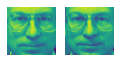

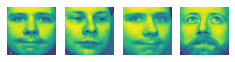

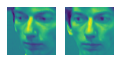

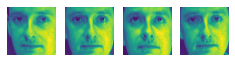

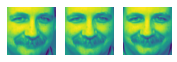

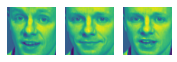

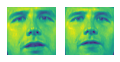

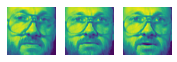

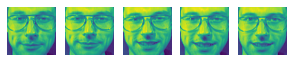

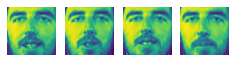

In [92]:
# Plotting first 10 clusters

def max_shape(array):
    max_sh = 0
    
    for i in array:
        max_sh = max(max_sh, i.shape[0])
    
    return max_sh
    
n_clusters = 10
biggest_cluster_size = max_shape(person[:n_clusters])

#fig, axs = plt.subplots(n_clusters, biggest_cluster_size)

plt.figure(figsize = (10, 10))

for i in range(10):
    counter = 1
    plt.figure(figsize=(5, biggest_cluster_size * 5.5))
    for j in range(person[i].shape[0]):
        plt.subplot(1, biggest_cluster_size, counter)
        plt.imshow(person[i][j].reshape((64,64)))
        plt.axis('off')
        counter = counter + 1
        
plt.show()

In [93]:
# The clustering worked very well!!

# Training classifiers

In [178]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)
X_test_s = scaler.transform(X_test)

In [182]:
# The random forest proved to be one of the best models for the MNIST dataset. Let's see how it handles this one

from sklearn.ensemble import RandomForestClassifier

rnd = RandomForestClassifier(random_state=42)
rnd.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [183]:
np.mean(y_val == rnd.predict(X_val))  # Not bad

0.90625

In [184]:
# Linear model *for later*

from sklearn.linear_model import SGDClassifier

lin = SGDClassifier(loss='log', random_state=42)
lin.fit(X_train_s, y_train)

SGDClassifier(loss='log', random_state=42)

In [185]:
np.mean(y_val == lin.predict(X_val_s))  # Not bad

0.90625

In [186]:
# SVM since there aren't many instances

from sklearn.svm import SVC

svc = SVC()
svc.fit(X_train_s, y_train)

SVC()

In [187]:
np.mean(y_val == svc.predict(X_val_s))  # WOW, even better than the random forest! And the training was super fast

0.9375

# Combining algorithms

In [188]:
from sklearn.base import clone

models = [rnd, lin, svc]
best_combo = []
scaler = StandardScaler()

def save_best_combo(n, model, score):
    global best_combo
    if best_combo == [] or best_combo[2] < score:
        best_combo = [n, model, score]
        print(best_combo)

for n in range(40, 151, 10):
    reducer = KMeans(n_clusters = n)
    reducer.fit(X_train)
    
    X_train_r, X_val_r = reducer.transform(X_train), reducer.transform(X_val)  # dimensionality reduction
    X_train_r = scaler.fit_transform(X_train_r)  # scaling required
    X_val_r = scaler.transform(X_val_r)          # scaling required 
    
    for model in models:
        model = clone(model)
        model.fit(X_train_r, y_train)
        save_best_combo(n, model, np.mean(y_val == model.predict(X_val_r)))

[40, RandomForestClassifier(random_state=42), 0.71875]
[40, SGDClassifier(loss='log', random_state=42), 0.796875]
[50, SGDClassifier(loss='log', random_state=42), 0.8125]
[80, SGDClassifier(loss='log', random_state=42), 0.828125]
[100, SGDClassifier(loss='log', random_state=42), 0.84375]
[110, SGDClassifier(loss='log', random_state=42), 0.859375]


In [189]:
# Yeah... The data was simpler (more linear), so the logistic regressor was benefitted the most. But nothing improved

# Combining datasets

In [190]:
reducer = KMeans(n_clusters = 120)
reducer.fit(X_train)

X_train_r, X_val_r = reducer.transform(X_train), reducer.transform(X_val)

In [191]:
X_train_c, X_val_c = np.c_[X_train, X_train_r], np.c_[X_val, X_val_r]

scaler = StandardScaler()

X_train_c = scaler.fit_transform(X_train_c)
X_val_c = scaler.transform(X_val_c)

In [192]:
pandas.DataFrame(X_train_c)

,0,1,2,3,4,5,6,7,8,9,...,4206,4207,4208,4209,4210,4211,4212,4213,4214,4215
0,-0.077028,0.118588,0.131511,0.147178,0.068954,0.004503,0.160432,0.220925,0.407050,0.597914,...,-1.449632,0.626369,0.911904,-0.797486,1.124809,0.941956,-0.470241,0.933534,1.066075,-0.947279
1,-1.829334,-1.371820,-1.858418,-1.877990,-1.140779,-0.257524,0.160432,0.100720,0.221025,0.306914,...,-0.429377,-0.044067,-1.442922,-0.153567,-0.206205,-0.304380,-0.258288,-0.006314,-0.793145,-0.368894
2,-0.544310,-0.317070,0.224066,0.288469,0.217085,-0.047902,-0.146690,-0.019486,0.159017,0.468581,...,0.213301,0.812078,2.686376,-0.606178,2.494880,2.372931,2.467336,0.740234,1.690981,0.005169
3,1.161268,1.012833,0.709979,0.453308,0.389903,0.161720,0.020831,-0.289950,-0.616085,-0.598419,...,1.498694,0.094628,-0.768213,0.856994,-0.381470,-0.502545,0.633561,0.143967,0.050479,0.673034
4,0.717350,0.737680,0.617424,0.429759,0.315838,0.240328,0.272113,0.130771,0.190021,0.080581,...,-0.213811,-0.322610,-0.989071,0.106287,-0.761497,-0.874654,-1.349823,-0.450537,-1.028039,-0.112991
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,-1.642422,-1.807478,-1.812140,-1.524763,-1.585170,-1.593864,-1.598544,-1.822577,-1.825245,-1.859419,...,2.741138,2.761561,1.144802,3.053219,-3.078931,-1.607025,1.070677,2.380967,2.235076,2.830329
252,1.301452,1.173338,1.057059,0.900729,0.710853,0.607167,0.383795,0.100720,0.003997,0.177581,...,0.836742,-0.757654,-1.077190,-0.430586,-0.317100,-0.045996,0.402238,-0.819431,-0.876284,0.207409
253,0.413617,0.691822,0.663701,0.688793,0.612099,0.580964,0.523396,0.521441,0.469058,0.403914,...,-0.560235,-0.214528,1.215443,-0.082915,0.981535,0.964667,0.085448,0.705099,1.039013,0.119075
254,-0.544310,-0.890304,-1.002286,-1.124439,-0.943271,-0.729173,-0.286292,-0.259898,-0.275040,-0.372086,...,0.149923,-1.585346,0.052575,-2.131530,0.864267,0.918109,1.167512,-1.091853,-0.425173,-0.592895


In [193]:
for model in models:
    model = clone(model)
    model.fit(X_train_c, y_train)
    print("Acc for ", model, ": ", np.mean(y_val == model.predict(X_val_c)), sep='')  # Pretty good, but not that impressing

Acc for RandomForestClassifier(random_state=42): 0.890625
Acc for SGDClassifier(loss='log', random_state=42): 0.90625
Acc for SVC(): 0.9375


# Detecting (generated) anomalies

In [194]:
# Let's train a gaussian mixture model. It abstracts the dataset into a composition of gaussian functions. With that, it can
# identify the dense regions of a dataset, and instances that are not in a dense region can be classified as anomalies.

# Also, it can generate data (in this case, pictures)

In [323]:
from sklearn.decomposition import PCA  # unfortunatelly, gaussianMixture is not efficient. We have to reduce the data first
from sklearn.mixture import GaussianMixture

pca = PCA(n_components = 0.999)
X_train_PCAed = pca.fit_transform(X_train)

print(pca.n_components_)   

242


In [213]:
bics = []

for i in range(1, 15):
    print(i, end=' ')
    mix = GaussianMixture(n_components = i, n_init = 10, random_state = 42)
    mix.fit(X_train_PCAed)
    print(mix.converged_, end=' ')
    bics.append(mix.bic(X_train_PCAed))

1 True 2 True 3 True 4 True 5 True 6 True 7 True 8 True 9 True 10 True 11 True 12 True 13 True 14 True 

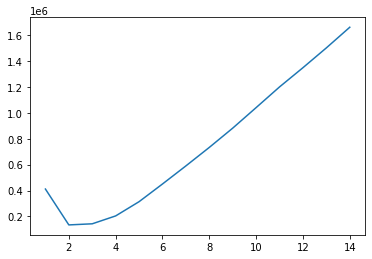

In [291]:
plt.plot(range(1, 15), bics)
plt.show()                      # the optimal number is low, but lets use more components in order to build a more complex model
                                # (it would "overfit", but that is not important for now)

In [297]:
mix = GaussianMixture(n_components = 100, n_init = 10)
mix.fit(X_train_PCAed)

GaussianMixture(n_components=100, n_init=10)

In [298]:
sample_r, label = mix.sample(n_samples = 10)
sample = pca.inverse_transform(sample_r)

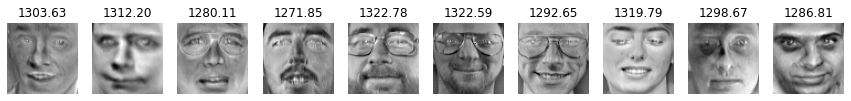

In [301]:
plt.figure(figsize = (15,150))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.title('%.2f' % mix.score(sample_r[i].reshape(1, -1)))  # likelihoods (pretty high)
    plt.axis('off')
    plt.imshow(sample[i].reshape(64, 64), cmap='gray')

plt.show()

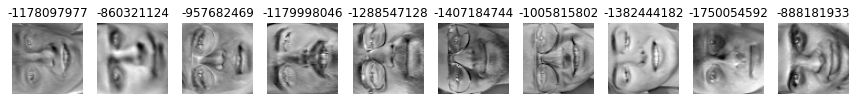

In [302]:
sample_imgs = sample.reshape(-1, 64, 64)
sample_anomalies = np.transpose(sample_imgs, (0, 2, 1))  # images that are not in the right orientation - anomalies!
sample_anomalies_r = pca.transform(sample_anomalies.reshape(-1, 64*64))

plt.figure(figsize = (15,150))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.title('%.0f' % mix.score(sample_anomalies_r[i].reshape(1, -1)))  # likelihoods (very, very low) - anomalies detected!!
    plt.axis('off')
    plt.imshow(sample_anomalies[i].reshape(64, 64), cmap='gray')

plt.show()

In [336]:
# another way would only involve the reconstruction error from PCA.

new_pca = PCA(n_components = pca.n_components_)  # making sure the PCAs have the same dimensions

#new_set = np.concatenate((X_train, sample_anomalies.reshape(-1, 64*64)), axis=0)
#print(new_set.shape)

new_pca.fit(X_train) # let's assume that the anomalies were NOT part of the train set

X_train_r = new_pca.transform(X_train[:10])
X_train_rec = new_pca.inverse_transform(X_train_r)

mse_original = np.square(X_train[:10] - X_train_rec).mean(axis=-1)
print("Loss (original):", mse_original.mean())  # very low, they aren't anomalies

Loss (original): 0.0003113325


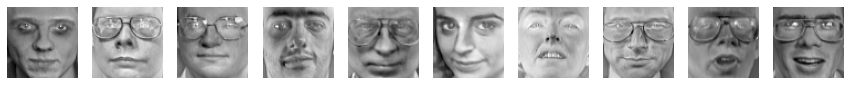

In [338]:
plt.figure(figsize = (15,150))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(X_train_rec[i].reshape(64, 64), cmap='gray')  # Good! They aren't anomalies
    
plt.show()

In [337]:
abominations = new_pca.transform(sample_anomalies.reshape(-1, 64*64))
abominations_rec = new_pca.inverse_transform(abominations)

mse_abominations = np.square(sample_anomalies.reshape(-1, 64*64) - abominations_rec).mean(axis=-1)
print("Loss (abominations):", mse_abominations.mean())  # very high, they are anomalies!!

Loss (abominations): 0.3203721613385996


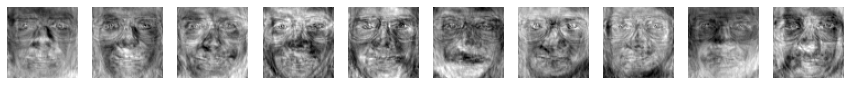

In [335]:
plt.figure(figsize = (15,150))

for i in range(10):
    plt.subplot(1, 10, i+1)
    plt.axis('off')
    plt.imshow(abominations_rec[i].reshape(64, 64), cmap='gray')  # Abominations indeed
    
plt.show()